## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The MultiONet method (Cartesian)


### (2.1) Prepare data

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_smh'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/smh_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/smh_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["sol"][...,n0:n0+ndata]).T, dtype)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, gridx, beta1, beta2
#
a_train, u_train, gridx_train, beta1_train, beta2_train = get_data(data_train, n_train, dtype)
a_test, u_test, gridx_test, beta1_test, beta2_test = get_data(data_test, n_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('The shape of beta1', beta1_train.shape, 'The shape of beta2', beta2_train.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
print('The shape of beta1', beta1_test.shape, 'The shape of beta2', beta2_test.shape)

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of gridx_train: torch.Size([841, 2])
The shape of beta1 torch.Size([1000, 1]) The shape of beta2 torch.Size([1000, 1])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])
The shape of beta1 torch.Size([200, 1]) The shape of beta2 torch.Size([200, 1])


### (2.2) Define the loss class

In [2]:
###############################
# Set normalizer
###############################
class Normalizer_a(object):

    def __init__(self, scale:float=1., shift:float=0.):
        self.scale = scale
        self.shift = shift
        
    def encode(self, a:torch.tensor):
        return a * self.scale - self.shift
        
    def decode(self, a:torch.tensor):
        return (a+self.shift)*self.scale
        
normalizer_a = Normalizer_a(1., 1.)

###############################
# Define Loss Class
###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']

    def Loss_data(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, self.model_enc(a_norm))
        #
        loss = self.solver.getLoss(u_pred, u)
        
        return loss

    def Error(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, self.model_enc(a_norm))
        #
        err = self.solver.getError(u_pred, u)
        
        return err

##############################
# Setup of the solver
##############################
import torch.nn as nn
from Networks.CNNet import CNNet2d
#
class EncoderNet(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, nx_size:int, ny_size:int, 
                 dtype, activation:str='SiLU'):
        super(EncoderNet, self).__init__()
        self.nx_size, self.ny_size = nx_size, ny_size
        self.conv = CNNet2d(conv_arch, fc_arch, 
                            activation_conv=activation, activation_fc=activation,
                            kernel_size=(5,5), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = x.reshape(-1, self.ny_size, self.nx_size).unsqueeze(1)
        x = self.conv(x)
        x = torch.relu(x)
        
        return x
#
model_enc = EncoderNet(conv_arch=[1, 32, 64, 128], fc_arch=[128*1*1,128], 
                       nx_size=29, ny_size=29, dtype=dtype).to(device)
######################################
# Steups of the model
######################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
netType = 'MultiONetCartesian'
#
hidden_list, act_x, act_a = [128]*4, 'ReLU', 'ReLU'
model_u = solver.getModel(x_in_size=2, a_in_size=128, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType='Cartesian')
# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u:,} total parameters')

273,536 training parameters.
149,000 training parameters.
422,536 total parameters


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
# Train the model
model_dict = {'u':model_u, 'enc':model_enc}
solver.train_setup(model_dict, lr=1e-3, optimizer='AdamW', scheduler_type='StepLR', step_size=200)
solver.train_cartesian(LossClass, a_train, u_train, gridx_train, a_test, u_test, gridx_test, 
                       batch_size=50, epochs=1000, epoch_show=100, 
                       **{'save_path':f'saved_models/{netType}/'})

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|███████▉                                                                       | 101/1000 [00:08<01:09, 12.85it/s]

Epoch:100 Time:8.6713, loss_train:0.180753, loss_test:0.136070
          lr: 0.001 err_test 0.023673422634601593


 20%|███████████████▉                                                               | 201/1000 [00:16<01:06, 12.04it/s]

Epoch:200 Time:16.4793, loss_train:0.105173, loss_test:0.129192
          lr: 0.0005 err_test 0.02487453818321228


 30%|███████████████████████▊                                                       | 301/1000 [00:24<00:53, 12.99it/s]

Epoch:300 Time:24.2702, loss_train:0.090299, loss_test:0.083652
          lr: 0.0005 err_test 0.015552333556115627


 40%|███████████████████████████████▋                                               | 401/1000 [00:32<00:48, 12.32it/s]

Epoch:400 Time:32.0040, loss_train:0.056013, loss_test:0.074902
          lr: 0.00025 err_test 0.014140205457806587


 50%|███████████████████████████████████████▌                                       | 501/1000 [00:39<00:38, 12.91it/s]

Epoch:500 Time:39.8533, loss_train:0.039028, loss_test:0.038822
          lr: 0.00025 err_test 0.00668293796479702


 60%|███████████████████████████████████████████████▍                               | 601/1000 [00:47<00:31, 12.67it/s]

Epoch:600 Time:47.5731, loss_train:0.037185, loss_test:0.039734
          lr: 0.000125 err_test 0.006865121424198151


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [00:55<00:22, 13.25it/s]

Epoch:700 Time:55.1750, loss_train:0.027458, loss_test:0.031980
          lr: 0.000125 err_test 0.005427288357168436


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:02<00:15, 12.71it/s]

Epoch:800 Time:62.8528, loss_train:0.026786, loss_test:0.030310
          lr: 6.25e-05 err_test 0.005128589924424887


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [01:10<00:07, 12.49it/s]

Epoch:900 Time:70.6905, loss_train:0.024484, loss_test:0.030068
          lr: 6.25e-05 err_test 0.005055059213191271


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.74it/s]

Epoch:1000 Time:78.4794, loss_train:0.023835, loss_test:0.028580
          lr: 3.125e-05 err_test 0.004791094921529293
The total training time is 78.4864


#### (2.3.2) make prediction

The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of meshgrid: torch.Size([841, 2])
The test loss tensor(0.0286)
The test l2 error: tensor(0.0048)


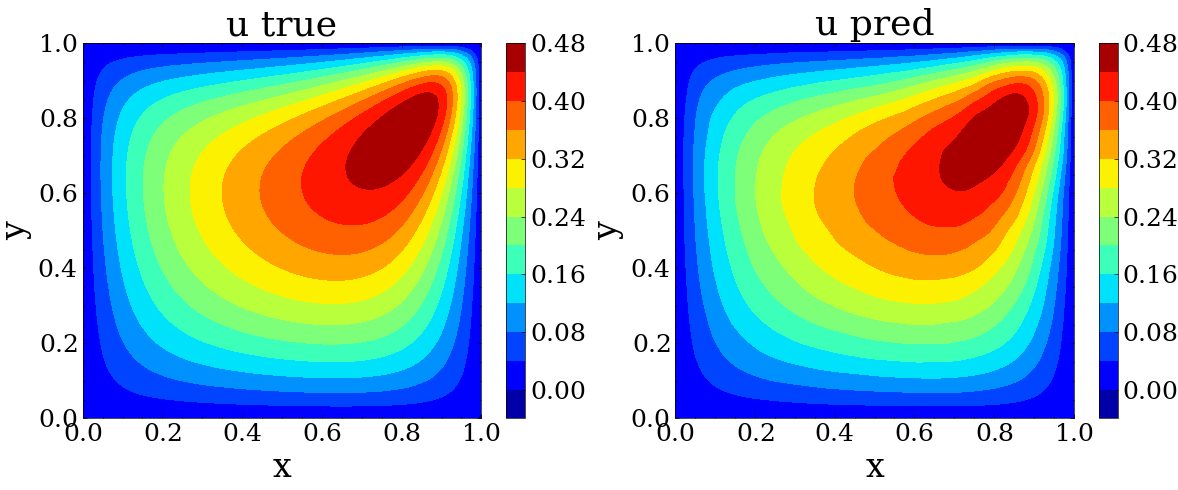

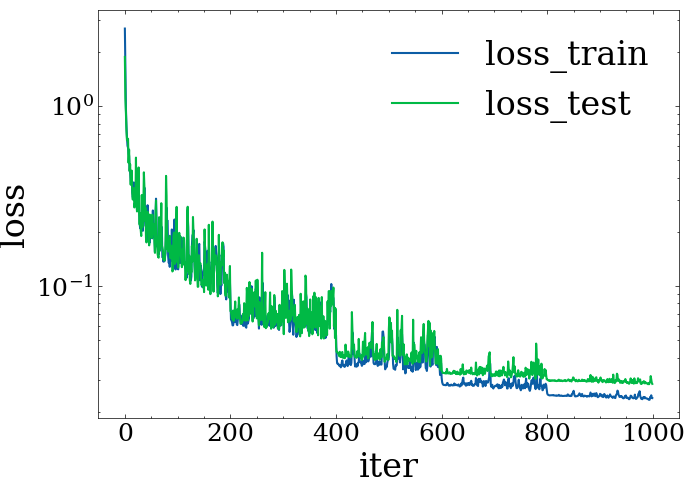

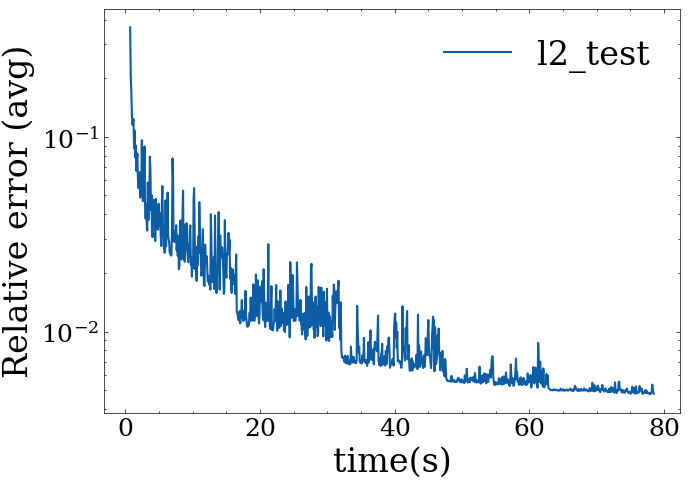

In [3]:
#####################################
# Load the trained model
#####################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_multionet_final')

#########################################
with torch.no_grad():
    a = normalizer_a.encode(a_test.to(device))
    u_pred = model_trained['u'](gridx_test.to(device), model_trained['enc'](a))
    u_pred = u_pred.detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of meshgrid:', gridx_test.shape)
print('The test loss', solver.getLoss(u_pred, u_test))
print('The test l2 error:', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx_test, [u_test[0], u_pred[0]], ['u true', 'u pred'], lb=0.)
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_multionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test']], ['l2_test'])